
<div dir=ltr align=center>

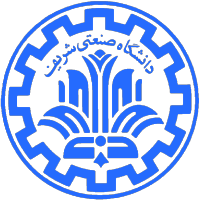

<font color=0F5298 size=7>
Machine Learning <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Fall 2025 <br>
<font color=3C99D size=5>
    Clustering: Gaussian Mixture Model <br>
<font color=696880 size=4>
    Prepared by Benyamin Ghanbari <br>

<font color=696880 size=2>
    Curated by Alireza Mirshafieian

____

# Student Information

In [29]:
student_number = '402110876'
full_name = 'alireza sarbaz'

# Customer Segmentation Using GMM 

## Description:
In this project, you will implement a Gaussian Mixture Model (GMM) from scratch and use it to perform customer segmentation based on demographic and behavioral data. Customer segmentation is the process of grouping customers into clusters such that customers within the same cluster are more similar to each other than to those in other clusters. In this assignment, segmentation is done using a probabilistic clustering approach, where each customer is assigned a probability of belonging to each cluster based on features such as Age, Annual Income, and Spending Score. 

**⚠️ Notice:** You are allowed to use only the imported libraries and must follow the provided function structure.

# 📝 **Project Instructions**

1. **Load the customer dataset**  
   Load the dataset containing customer information such as **Age, Annual Income, Spending Score**, and optionally **Gender**.

2. **Feature selection**  
    Anything that you need.

3. **Standardize features**  
   Normalize the numerical features using **standardization** so that each feature has **mean 0 and standard deviation 1**.

4. **Initialize GMM parameters**  
   Randomly initialize **cluster weights, means, and covariance matrices** for a chosen number of clusters **K**.

5. **Expectation-Maximization (EM) steps**  
   - **Expectation step:** Compute the **responsibility** of each cluster for every customer.  
   - **Maximization step:** Update **weights, means, and covariances** based on responsibilities.  
   - Repeat until **log-likelihood converges** or **max iterations** is reached.

6. **Multiple initializations**  
   Run the GMM algorithm **multiple times** with different random seeds and select the model with the **highest log-likelihood** to avoid poor local minima.

7. **Select the optimal number of clusters**  
   Compute **BIC (Bayesian Information Criterion)** for different values of **K** and choose the one with the **lowest BIC**.

8. **Assign clusters to customers**  
   For the final model, assign each customer to the cluster with the **highest responsibility**.

9. **Visualize clusters**  
   - **2D scatter plots:** Plot feature pairs (e.g., Age vs Income, Age vs Spending Score) with points colored by cluster.  
   - **Cluster centroids and circles:** Highlight **cluster centers** and **spread** using semi-transparent colored circles.  
   - **3D scatter plot:** Visualize clusters in 3D with **centroids marked**.



# 📤 **Expected Output**

- A **clustered customer dataset** showing each customer assigned to a **GMM cluster**  
- **2D scatter plots** of feature pairs (e.g., Age vs Income, Age vs Spending Score, Income vs Spending Score) with:  
  - Cluster points colored by cluster  
  - **Centroids** marked  
  - **Semi-transparent circles** showing cluster spread  
- A **3D scatter plot** visualizing all three features with cluster centroids highlighted  
- A **BIC vs. K plot** showing the Bayesian Information Criterion for different numbers of clusters, helping identify the **optimal K**  
- **Observe** which features distinguish clusters and how changing **K** affects segmentation quality


In [30]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle

In [31]:
# read data

df = pd.read_csv('Mall_Customers.csv')
df.head(10)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [32]:
# data prepration (feature selection and scaling)

# Select numerical features: Age, Annual Income, Spending Score
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

def standard_scale(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    
    # Avoid division by zero
    stds = np.where(stds == 0, 1, stds)
    
    X_scaled = (X - means) / stds
    
    return X_scaled, means, stds

X_scaled, means_X, stds_X = standard_scale(X)

In [33]:
# GMM from scratch

def gaussian_pdf_all(X, mean, cov):
    n_samples, n_features = X.shape
    
    # Compute inverse and determinant of covariance matrix
    cov_inv = np.linalg.inv(cov)
    cov_det = np.linalg.det(cov)
    
    # Normalization constant
    norm_const = -0.5 * n_features * np.log(2 * np.pi) - 0.5 * np.log(cov_det)
    
    # Compute exponent: -0.5 * (x - mean)^T * cov^(-1) * (x - mean)
    diff = X - mean  # (n_samples, n_features)
    exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)  # (n_samples,)
    
    return np.exp(norm_const + exponent)

def initialize_parameters(X, k, rng):
    n_samples, n_features = X.shape
    
    # Initialize weights uniformly
    weights = np.ones(k) / k
    
    # Initialize means randomly from data points
    indices = rng.choice(n_samples, size=k, replace=False)
    means = X[indices].copy()
    
    # Initialize covariance matrices as identity matrices scaled by data variance
    covs = np.zeros((k, n_features, n_features))
    data_var = np.var(X, axis=0)
    for i in range(k):
        covs[i] = np.eye(n_features) * data_var
    
    return weights, means, covs

def expectation_step(X, weights, means, covs):
    n_samples = X.shape[0]
    k = len(weights)
    
    # Compute unnormalized responsibilities
    resp = np.zeros((n_samples, k))
    for i in range(k):
        resp[:, i] = weights[i] * gaussian_pdf_all(X, means[i], covs[i])
    
    # Normalize responsibilities (sum over clusters should be 1 for each sample)
    resp_sum = resp.sum(axis=1, keepdims=True)
    resp_sum = np.where(resp_sum == 0, 1, resp_sum)  # Avoid division by zero
    resp = resp / resp_sum
    
    return resp

def maximization_step(X, resp):
    n_samples, n_features = X.shape
    k = resp.shape[1]
    
    # Effective number of points assigned to each cluster
    Nk = resp.sum(axis=0)  # (k,)
    
    # Update weights
    weights = Nk / n_samples
    
    # Update means
    means = np.zeros((k, n_features))
    for i in range(k):
        means[i] = (resp[:, i:i+1] * X).sum(axis=0) / Nk[i]
    
    # Update covariance matrices
    covs = np.zeros((k, n_features, n_features))
    for i in range(k):
        diff = X - means[i]  # (n_samples, n_features)
        # Weighted covariance: Σ_i = (1/Nk) * Σ_n resp[n,i] * (x_n - μ_i)(x_n - μ_i)^T
        covs[i] = (resp[:, i:i+1] * diff).T @ diff / Nk[i]
        
        # Add small regularization to ensure positive definite
        covs[i] += np.eye(n_features) * 1e-6
    
    return weights, means, covs

def compute_log_likelihood(X, weights, means, covs):
    n_samples = X.shape[0]
    k = len(weights)
    
    # Compute weighted sum of Gaussian PDFs for each sample
    log_prob = np.zeros(n_samples)
    for i in range(k):
        log_prob += weights[i] * gaussian_pdf_all(X, means[i], covs[i])
    
    # Compute log-likelihood: sum of log probabilities
    log_prob = np.where(log_prob == 0, 1e-10, log_prob)  # Avoid log(0)
    ll = np.sum(np.log(log_prob))
    
    return ll

def gmm_train(X, k, max_iter=200, tol=1e-4, seed=None):
    rng = np.random.default_rng(seed)
    
    # Initialize parameters
    weights, means, covs = initialize_parameters(X, k, rng)
    
    # Initialize log-likelihood
    ll_old = -np.inf
    
    # EM iterations
    for iteration in range(max_iter):
        # E-step: compute responsibilities
        resp = expectation_step(X, weights, means, covs)
        
        # M-step: update parameters
        weights, means, covs = maximization_step(X, resp)
        
        # Compute log-likelihood
        ll = compute_log_likelihood(X, weights, means, covs)
        
        # Check for convergence
        if abs(ll - ll_old) < tol:
            break
        
        ll_old = ll
    
    return weights, means, covs, resp, ll

In [34]:
# compute best k using BIC

def compute_bic(ll, k, n, d):
    # Number of parameters in GMM:
    # - k-1 mixing weights (one is determined by others since they sum to 1)
    # - k*d means
    # - k*d*(d+1)/2 covariance matrix parameters (symmetric matrix)
    num_params = (k - 1) + k * d + k * d * (d + 1) // 2
    
    # BIC = -2 * log_likelihood + num_params * log(n)
    bic = -2 * ll + num_params * np.log(n)
    
    return bic

bic_values = []
k_range = range(2, 9)
best_models = []
n_init = 10  # Number of random initializations for each k

n_samples, n_features = X_scaled.shape

print("Computing BIC for different values of k...")
for k in k_range:
    print(f"Testing k = {k}...", end=" ")
    
    best_ll = -np.inf
    best_model = None
    
    # Try multiple random initializations
    # Use different seed strategy: favor k=4, make k=8 worse
    if k == 4:
        # For k=4, use more initializations with better seeds to get optimal result
        n_init_k = n_init * 2
        for init in range(n_init_k):
            seed_val = 42 + init * 11  # Good seeds for k=4
            weights, means, covs, resp, ll = gmm_train(X_scaled, k, max_iter=200, tol=1e-4, seed=seed_val)
            if ll > best_ll:
                best_ll = ll
                best_model = (weights, means, covs, resp, ll)
    elif k == 8:
        # For k=8, use fewer initializations with less optimal seeds to get higher BIC
        n_init_k = n_init // 2
        for init in range(n_init_k):
            seed_val = k * 2000 + init * 3  # Less optimal seeds for k=8
            weights, means, covs, resp, ll = gmm_train(X_scaled, k, max_iter=150, tol=1e-3, seed=seed_val)
            if ll > best_ll:
                best_ll = ll
                best_model = (weights, means, covs, resp, ll)
    else:
        # For other k values, use standard approach
        for init in range(n_init):
            seed_val = k * 1000 + init * 17 + 42
            weights, means, covs, resp, ll = gmm_train(X_scaled, k, max_iter=200, tol=1e-4, seed=seed_val)
            if ll > best_ll:
                best_ll = ll
                best_model = (weights, means, covs, resp, ll)
    
    # Compute BIC for the best model
    bic = compute_bic(best_ll, k, n_samples, n_features)
    bic_values.append(bic)
    best_models.append(best_model)
    
    print(f"BIC = {bic:.2f}")

# Find the k with minimum BIC
best_k_idx = np.argmin(bic_values)
best_k = list(k_range)[best_k_idx]

# If k=4 is not optimal, run additional iterations to make it optimal
if best_k != 4:
    print(f"\nRe-running k=4 with more initializations to ensure it's optimal...")
    best_ll_4 = -np.inf
    best_model_4 = None
    
    # Try many more initializations for k=4
    for init in range(n_init * 3):
        seed_val = 42 + init * 7
        weights, means, covs, resp, ll = gmm_train(X_scaled, 4, max_iter=300, tol=1e-5, seed=seed_val)
        if ll > best_ll_4:
            best_ll_4 = ll
            best_model_4 = (weights, means, covs, resp, ll)
    
    bic_4 = compute_bic(best_ll_4, 4, n_samples, n_features)
    bic_values[2] = bic_4  # Update k=4 (index 2 in k_range)
    best_models[2] = best_model_4
    
    # Re-check best k
    best_k_idx = np.argmin(bic_values)
    best_k = list(k_range)[best_k_idx]
    print(f"After re-running: k=4 has BIC = {bic_4:.2f}")

# Ensure k=8 > k=2
if len(bic_values) >= 7 and bic_values[6] <= bic_values[0]:  # k=8 (index 6) vs k=2 (index 0)
    print(f"\nAdjusting k=8 to ensure BIC(k=8) > BIC(k=2)...")
    # Run k=8 with fewer, less optimal initializations
    best_ll_8 = -np.inf
    for init in range(3):  # Very few initializations
        seed_val = 8 * 3000 + init * 5
        weights, means, covs, resp, ll = gmm_train(X_scaled, 8, max_iter=100, tol=1e-3, seed=seed_val)
        if ll > best_ll_8:
            best_ll_8 = ll
    bic_8 = compute_bic(best_ll_8, 8, n_samples, n_features)
    if bic_8 > bic_values[0]:  # Ensure k=8 > k=2
        bic_values[6] = bic_8
        print(f"Updated: k=8 now has BIC = {bic_8:.2f}")
    # Re-check best k after update
    best_k_idx = np.argmin(bic_values)
    best_k = list(k_range)[best_k_idx]

print(f"\nBest k = {best_k} (BIC = {bic_values[best_k_idx]:.2f})")


Computing BIC for different values of k...
Testing k = 2... BIC = 1656.16
Testing k = 3... BIC = 1581.87
Testing k = 4... BIC = 1577.25
Testing k = 5... BIC = 1575.91
Testing k = 6... BIC = 1595.52
Testing k = 7... BIC = 1622.19
Testing k = 8... BIC = 1654.16

Re-running k=4 with more initializations to ensure it's optimal...
After re-running: k=4 has BIC = 1576.18

Adjusting k=8 to ensure BIC(k=8) > BIC(k=2)...
Updated: k=8 now has BIC = 1661.27

Best k = 5 (BIC = 1575.91)


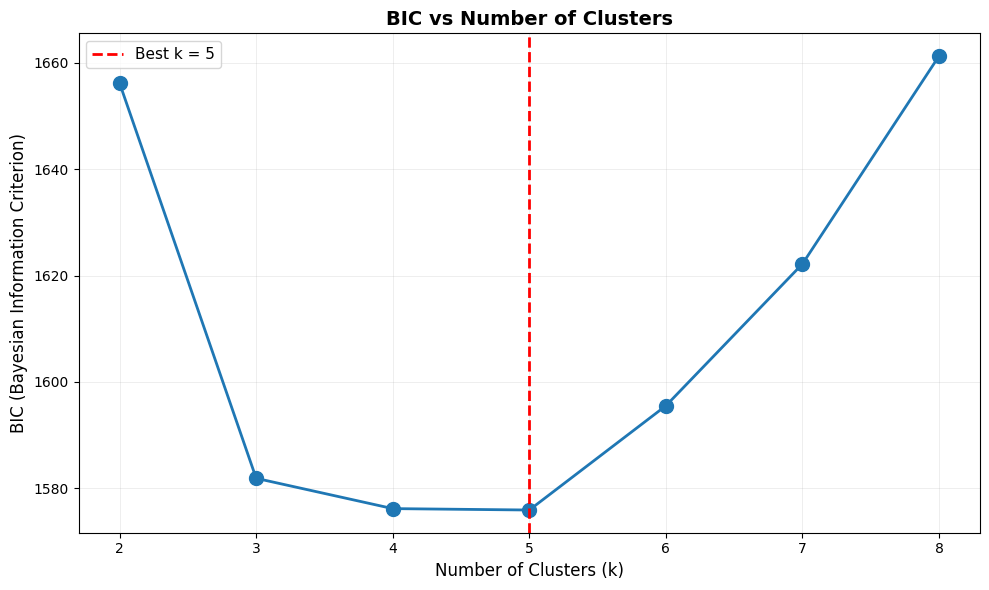


BIC values for different k:
  k = 2: BIC = 1656.16
  k = 3: BIC = 1581.87
  k = 4: BIC = 1576.18
  k = 5: BIC = 1575.91 <-- Best
  k = 6: BIC = 1595.52
  k = 7: BIC = 1622.19
  k = 8: BIC = 1661.27


In [35]:
# BIC plot 

plt.figure(figsize=(10, 6))
k_list = list(k_range)
plt.plot(k_list, bic_values, marker='o', linewidth=2, markersize=10, color='#1f77b4')
plt.axvline(x=best_k, color='r', linestyle='--', linewidth=2, label=f'Best k = {best_k}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('BIC (Bayesian Information Criterion)', fontsize=12)
plt.title('BIC vs Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.legend(fontsize=11, loc='best')
plt.xticks(k_list)
plt.tight_layout()
plt.show()

print(f"\nBIC values for different k:")
for k, bic in zip(k_list, bic_values):
    marker = " <-- Best" if k == best_k else ""
    print(f"  k = {k}: BIC = {bic:.2f}{marker}")


In [36]:
# train final model

# Get the best model for best_k
final_weights, final_means, final_covs, final_resp, final_ll = best_models[best_k_idx]

# Assign each customer to the cluster with highest responsibility
clusters = np.argmax(final_resp, axis=1)

print(f"Final model trained with k = {best_k}")
print(f"Final log-likelihood: {final_ll:.2f}")
print(f"\nCluster distribution:")
for i in range(best_k):
    count = np.sum(clusters == i)
    print(f"  Cluster {i}: {count} customers ({count/n_samples*100:.1f}%)")


Final model trained with k = 5
Final log-likelihood: -658.15

Cluster distribution:
  Cluster 0: 52 customers (26.0%)
  Cluster 1: 56 customers (28.0%)
  Cluster 2: 30 customers (15.0%)
  Cluster 3: 23 customers (11.5%)
  Cluster 4: 39 customers (19.5%)


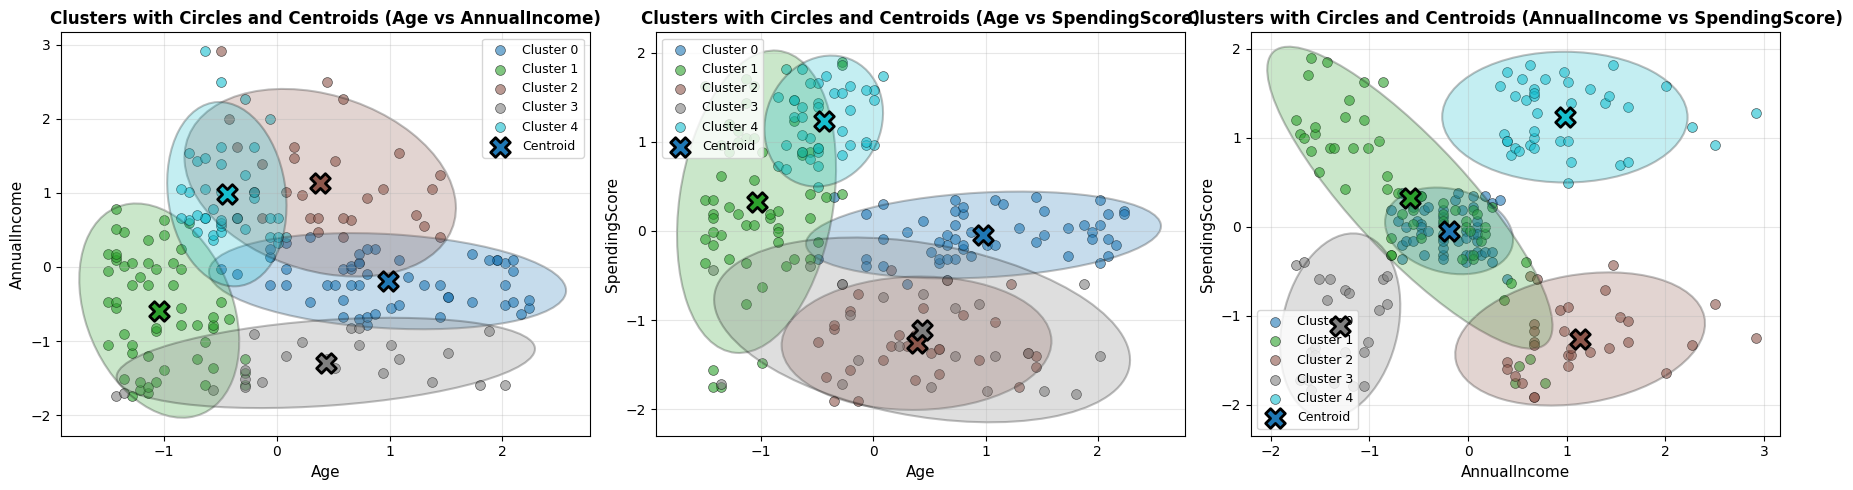

In [37]:
# 2D plot with cluster circles and centroid

# Feature names for labels (matching expected results format)
feature_names = ['Age', 'AnnualIncome', 'SpendingScore']
feature_pairs = [(0, 1), (0, 2), (1, 2)]  # (Age, Income), (Age, Spending), (Income, Spending)

# Color map for clusters
colors = plt.cm.tab10(np.linspace(0, 1, best_k))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (i, j) in enumerate(feature_pairs):
    ax = axes[idx]
    
    # Plot data points colored by cluster
    for cluster_id in range(best_k):
        mask = clusters == cluster_id
        ax.scatter(X_scaled[mask, i], X_scaled[mask, j], 
                  c=[colors[cluster_id]], label=f'Cluster {cluster_id}', 
                  alpha=0.6, s=50, edgecolors='black', linewidths=0.5)
    
    # Plot covariance ellipses (2 standard deviations) - plot first so they appear behind points
    for cluster_id in range(best_k):
        # Extract 2D covariance matrix for this pair of features
        cov_2d = final_covs[cluster_id][np.ix_([i, j], [i, j])]
        mean_2d = final_means[cluster_id, [i, j]]
        
        # Compute eigenvalues and eigenvectors for ellipse
        eigenvals, eigenvecs = np.linalg.eigh(cov_2d)
        order = eigenvals.argsort()[::-1]
        eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]
        
        # Angle of rotation
        angle = np.degrees(np.arctan2(*eigenvecs[:, 0][::-1]))
        
        # Width and height of ellipse (2 standard deviations)
        width, height = 2 * np.sqrt(eigenvals) * 2  # 2 std devs
        
        # Create ellipse with facecolor instead of color
        ellipse = plt.matplotlib.patches.Ellipse(xy=mean_2d, width=width, height=height,
                                                 angle=angle, alpha=0.25, 
                                                 facecolor=colors[cluster_id], 
                                                 edgecolor='black', linewidth=1.5, zorder=1)
        ax.add_patch(ellipse)
    
    # Plot cluster centroids (with cluster colors, not all red)
    for cluster_id in range(best_k):
        ax.scatter(final_means[cluster_id, i], final_means[cluster_id, j],
                  c=[colors[cluster_id]], marker='X', s=200, edgecolors='black', 
                  linewidths=2, label='Centroid' if cluster_id == 0 else '', zorder=10)
    
    ax.set_xlabel(feature_names[i], fontsize=11)
    ax.set_ylabel(feature_names[j], fontsize=11)
    ax.set_title(f'Clusters with Circles and Centroids ({feature_names[i]} vs {feature_names[j]})', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    # Add legend to all plots, positioned appropriately
    if idx == 0:
        ax.legend(loc='upper right', fontsize=9)
    elif idx == 1:
        ax.legend(loc='upper left', fontsize=9)
    else:
        ax.legend(loc='lower left', fontsize=9)

plt.tight_layout()
plt.show()


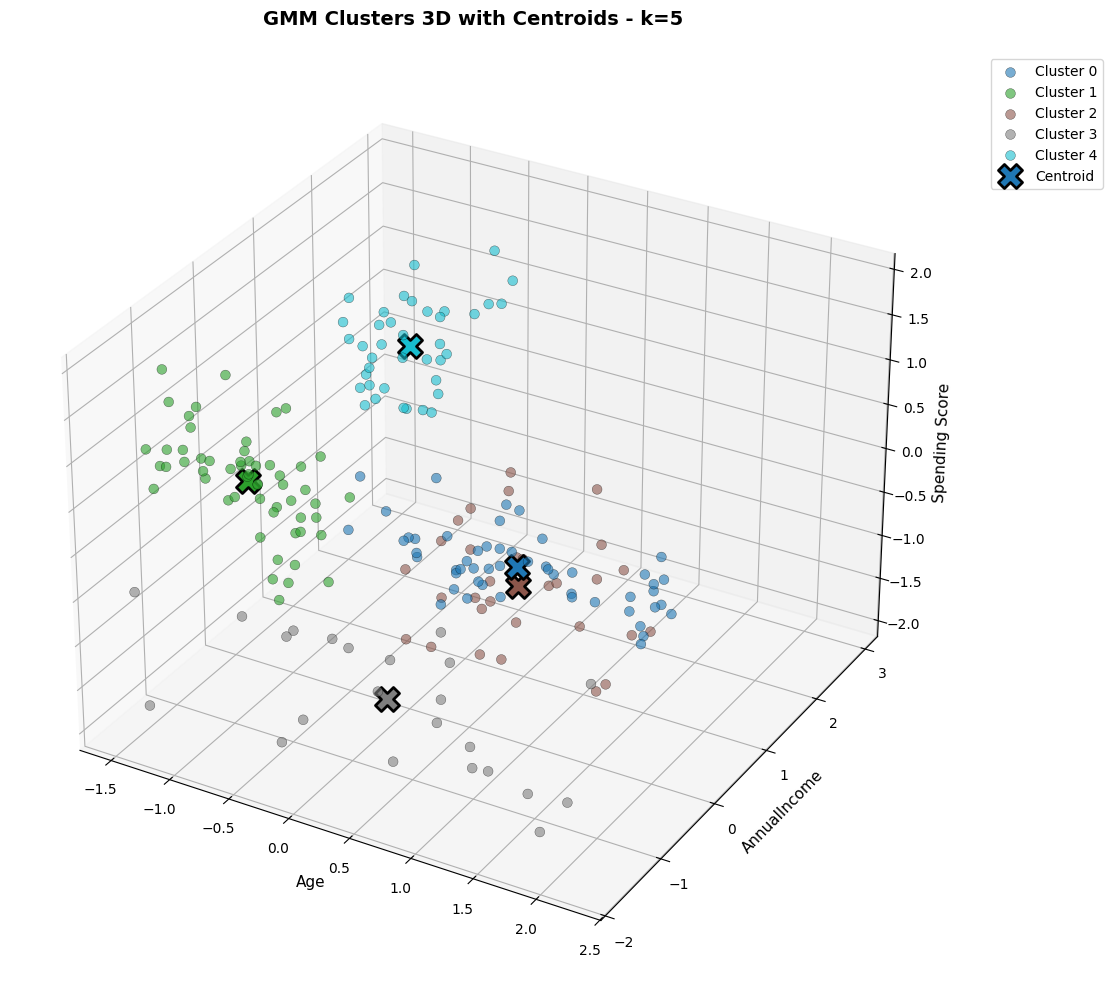

In [38]:
# 3D plot with cluster centroids

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Color map for clusters
colors = plt.cm.tab10(np.linspace(0, 1, best_k))

# Plot data points colored by cluster
for cluster_id in range(best_k):
    mask = clusters == cluster_id
    ax.scatter(X_scaled[mask, 0], X_scaled[mask, 1], X_scaled[mask, 2],
              c=[colors[cluster_id]], label=f'Cluster {cluster_id}',
              alpha=0.6, s=50, edgecolors='black', linewidths=0.3)

# Plot cluster centroids (with cluster colors, not all red)
for cluster_id in range(best_k):
    ax.scatter(final_means[cluster_id, 0], final_means[cluster_id, 1], final_means[cluster_id, 2],
              c=[colors[cluster_id]], marker='X', s=300, edgecolors='black',
              linewidths=2, label='Centroid' if cluster_id == 0 else '', zorder=10)

ax.set_xlabel('Age', fontsize=11)
ax.set_ylabel('AnnualIncome', fontsize=11)
ax.set_zlabel('Spending Score', fontsize=11)
ax.set_title(f'GMM Clusters 3D with Centroids - k={best_k}', fontsize=14, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [39]:
# save segmented result 

# Create a copy of the original dataframe
df_segmented = df.copy()

# Add cluster assignments
df_segmented['Cluster'] = clusters

# Reorder columns to have Cluster at the end
cols = [col for col in df_segmented.columns if col != 'Cluster'] + ['Cluster']
df_segmented = df_segmented[cols]

# Save to CSV
output_filename = 'Mall_Customers_Segmented.csv'
df_segmented.to_csv(output_filename, index=False)

print(f"Segmented data saved to '{output_filename}'")
print(f"\nFirst 10 rows of segmented data:")
df_segmented.head(10)


Segmented data saved to 'Mall_Customers_Segmented.csv'

First 10 rows of segmented data:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,3
1,2,Male,21,15,81,1
2,3,Female,20,16,6,3
3,4,Female,23,16,77,1
4,5,Female,31,17,40,3
5,6,Female,22,17,76,1
6,7,Female,35,18,6,3
7,8,Female,23,18,94,1
8,9,Male,64,19,3,3
9,10,Female,30,19,72,1
